# Finding Enron persons of interest from email and financial data 

In [279]:
# Imports 
import sys
import pickle
sys.path.append("../tools/")

import pandas as pd
from ggplot import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cross_validation import train_test_split

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

In [196]:
# load date and transform to dataframe 
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

# As soon as you print the data frame you see the'Total' 
# row is present from the spreadsheet and needs removed
data_dict.pop('TOTAL',0)

df = pd.DataFrame.from_dict(data_dict, orient = 'index')

## Understanding the Dataset and Question

In [93]:
print "In our dataset we have"
print 'Observations(Enron employees): %s' % df.shape[0]
print 'Features: %s' % df.shape[1]
poi_count = sum(df['poi'])
poi_percent = round(poi_count/float(df.shape[0]),4) * 100
print "With %s of them (%s%%) being persons of interest" % (poi_count, poi_percent)

In our dataset we have
Observations(Enron employees): 145
Features: 21
With 18 of them (12.41%) being persons of interest


When we preview our dataset, it looks like there will be a lot of data missing throughout it:

In [74]:
df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,...,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,...,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,...,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN


 Let's get a handle on how many missing observations there are for each column:

In [80]:
def percent_missing(df, cutoff_percent = 0.):
    for col in df.columns:
        try:
            missing_percent = sum(df[col] == 'NaN')/float(df.shape[0])
            if missing_percent >= cutoff_percent:
                print col, round(missing_percent, 2)
        except:
            # This is just poi bool
            pass

percent_missing(df)

salary 0.35
to_messages 0.41
deferral_payments 0.74
total_payments 0.14
exercised_stock_options 0.3
bonus 0.44
restricted_stock 0.25
shared_receipt_with_poi 0.41
restricted_stock_deferred 0.88
total_stock_value 0.14
expenses 0.35
loan_advances 0.98
from_messages 0.41
other 0.37
from_this_person_to_poi 0.41
director_fees 0.89
deferred_income 0.67
long_term_incentive 0.55
email_address 0.23
from_poi_to_this_person 0.41


So it looks like we are missing some values in every field we have (besides poi which is not listed here) but we kind of expected as much with messy data. Let's focus on the most worysome ones.

In [82]:
percent_missing(df, .5)

deferral_payments 0.74
restricted_stock_deferred 0.88
loan_advances 0.98
director_fees 0.89
deferred_income 0.67
long_term_incentive 0.55


With these values missing in over half of observations, we will want to be especially cautious about how we use them. Althrough since we are hunting for very specific people that only make up 12% of the observations, it is possible some of them could be very useful.

With loan_advances only appearing in 2% I'll be removing it.

In [241]:
df = df.drop('loan_advances',axis=1)

In [280]:
df_filled = df.replace('NaN',0)
df_filled['email_address'] = df_filled['email_address'].replace(0, 'None')

Outliers are going to be tricky with this data set. I wanted to find the most agredious outliers but with so much missing data as 0s and the insanely high financial benifits some of these people were recieving, I had to go all the way up to features that have a max value seven standard deviations above the mean to focus on half the features.

It looks like most of the features with big outliers are compensation items besides normal salary and bonuses. This kind of makes sense though with there be hevily compensated execs and normal employees so we don't know that any of these are actually problematic and will have to look into them more individually.

In [249]:
# setting to not use scientific notation since that made this harder to read
pd.set_option('display.float_format', lambda x: '%.3f' % x)

largest_outliers = [x for x in df_description if 
                    df_description[x]['max'] > df_description[x]['mean'] + df_description[x]['std'] * 7]

df_description[largest_outliers]

,deferral_payments,total_payments,restricted_stock_deferred,total_stock_value,from_messages,other,from_this_person_to_poi,long_term_incentive
count,145.000,145.000,145.000,145.000,145.000,145.000,145.000,145.000
mean,220557.903,2243477.421,72911.572,2889718.124,361.076,295210.021,24.455,334633.986
std,751704.629,8817819.452,1297469.064,6172223.036,1445.945,1127404.270,79.527,685363.856
min,-102500.000,0.000,-1787380.000,-44093.000,0.000,0.000,0.000,0.000
25%,0.000,91093.000,0.000,221141.000,0.000,0.000,0.000,0.000
50%,0.000,916197.000,0.000,955873.000,17.000,947.000,0.000,0.000
75%,7961.000,1934359.000,0.000,2282768.000,52.000,150458.000,14.000,374347.000
max,6426990.000,103559793.000,15456290.000,49110078.000,14368.000,10359729.000,609.000,5145434.000


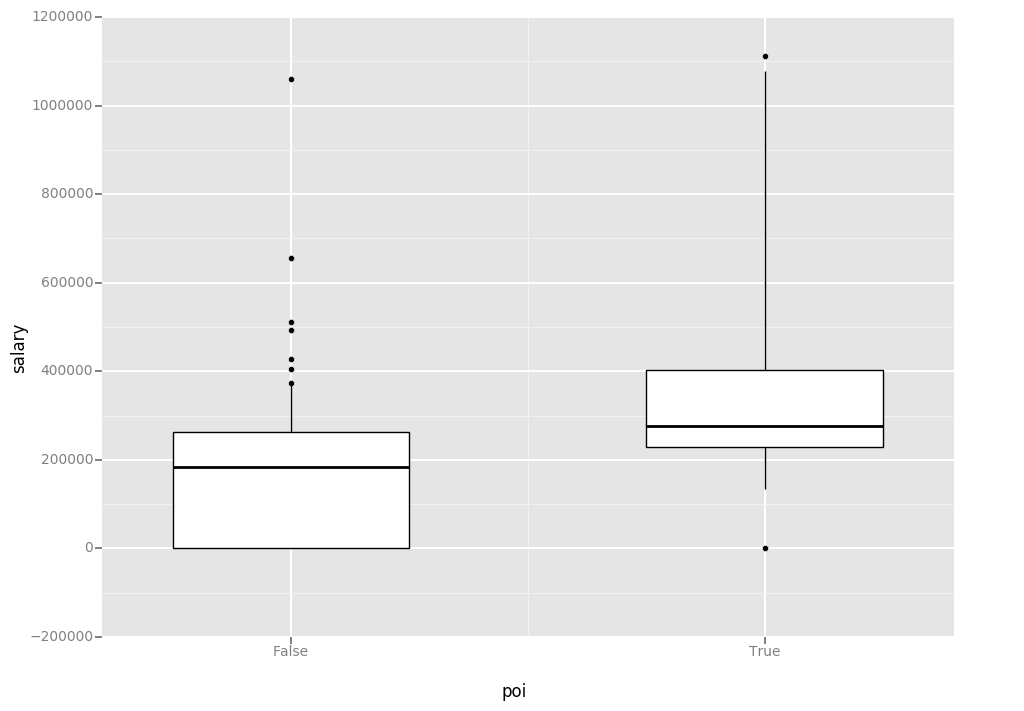

<ggplot: (293764973)>

In [250]:
ggplot(aes('poi','salary'), data = df_filled) +\
    geom_boxplot()

## Optimize Feature Selection/Engineering

People that recieve a director fee seem to be different from regular company employees, they don't draw a salary or bonuses and instead are compensated in stockes and director fees. I would like to see if using director as a boolian is more informative that specific values. 

In [164]:
df['director'] = df['director_fees'] != 'NaN'
df[df['director_fees'] != 'NaN']

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person,percent_from_emails_to_poi,percent_from_emails_from_poi,percent_emails_from_poi,director
BELFER ROBERT,NaN,NaN,-102500,102500,3285,NaN,NaN,NaN,44093,-44093,...,False,3285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
BHATNAGAR SANJAY,NaN,523,NaN,15456290,2604490,NaN,-2604490,463,15456290,NaN,...,False,137864,NaN,NaN,sanjay.bhatnagar@enron.com,0,0.0345,0,0,True
BLAKE JR. NORMAN P,NaN,NaN,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN,...,False,113784,-113784,NaN,NaN,NaN,NaN,NaN,NaN,True
CHAN RONNIE,NaN,NaN,NaN,NaN,NaN,NaN,32460,NaN,-32460,NaN,...,False,98784,-98784,NaN,NaN,NaN,NaN,NaN,NaN,True
DUNCAN JOHN H,NaN,NaN,NaN,77492,371750,NaN,NaN,NaN,NaN,371750,...,False,102492,-25000,NaN,NaN,NaN,NaN,NaN,NaN,True
GRAMM WENDY L,NaN,NaN,NaN,119292,NaN,NaN,NaN,NaN,NaN,NaN,...,False,119292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
JAEDICKE ROBERT,NaN,NaN,NaN,83750,431750,NaN,44093,NaN,-44093,431750,...,False,108750,-25000,NaN,NaN,NaN,NaN,NaN,NaN,True
LEMAISTRE CHARLES,NaN,NaN,NaN,87492,412878,NaN,NaN,NaN,NaN,412878,...,False,112492,-25000,NaN,NaN,NaN,NaN,NaN,NaN,True
MENDELSOHN JOHN,NaN,NaN,NaN,148,NaN,NaN,NaN,NaN,NaN,NaN,...,False,103750,-103750,NaN,NaN,NaN,NaN,NaN,NaN,True
MEYER JEROME J,NaN,NaN,NaN,2151,NaN,NaN,NaN,NaN,NaN,NaN,...,False,38346,-38346,NaN,NaN,NaN,NaN,NaN,NaN,True


I am also making features of what percent of emails were to/from pois instead of the straight counts that we have in the data set.

In [155]:
def email_percents(poi_emails, all_emails):
    percent_emails_to_poi = []
    for from_poi, all_from in zip(df[poi_emails], df[all_emails]):
        try:
            perc_to_poi = float(from_poi)/all_from
            percent_emails_to_poi.append(round(perc_to_poi,4))
        except:
            percent_emails_to_poi.append('NaN')
    return percent_emails_to_poi

df['percent_from_emails_to_poi'] = email_percents('from_this_person_to_poi', 'from_messages')
df['percent_emails_from_poi'] = email_percents('from_poi_to_this_person', 'to_messages')

From the plots below, it looks like the percents will be a more helpful parameter since it at least gives us some decent sized areas with only non pois.

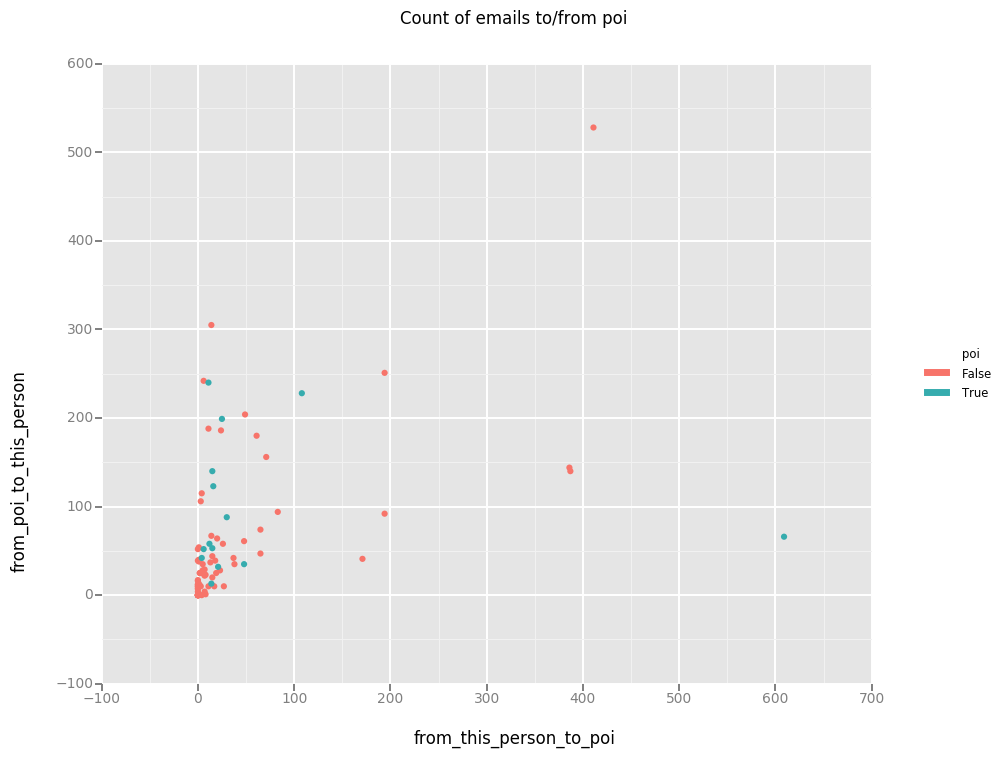

<ggplot: (290369117)>

In [156]:
ggplot(aes(x = 'from_this_person_to_poi', y = 'from_poi_to_this_person',
           color = 'poi' ), data = df ) +\
    geom_point() +\
    labs(title = "Count of emails to/from poi")

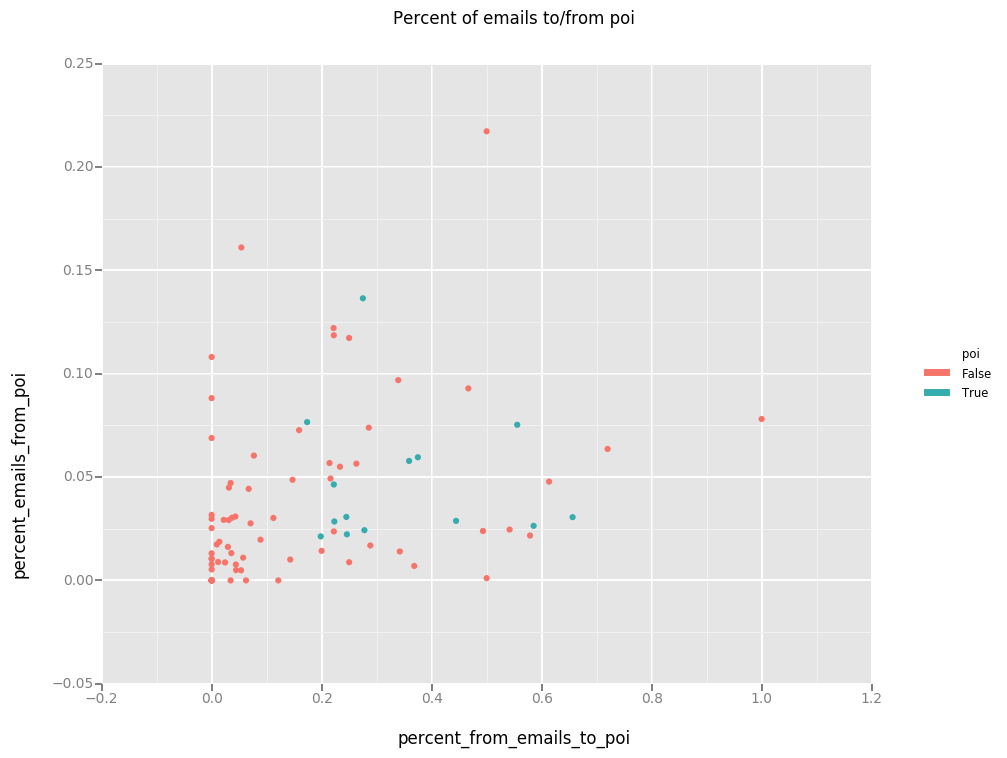

<ggplot: (290371793)>

In [157]:
ggplot(aes(x = 'percent_from_emails_to_poi', y = 'percent_emails_from_poi',
           color = 'poi' ), data = df ) +\
    geom_point()+\
    labs(title = "Percent of emails to/from poi")

I was initially concerned about the person who sent 100% of their emails to a poi, but Gene Humphrey seems to be accurate, so we won't toss it as an outlier.

In [166]:
df[df['percent_from_emails_to_poi']==1][
    ['from_this_person_to_poi', 'from_messages', 'percent_from_emails_to_poi']]

,from_this_person_to_poi,from_messages,percent_from_emails_to_poi
HUMPHREY GENE E,17,17,1


In [281]:
df_filled = df.replace('NaN',0)
df_filled['email_address'] = df_filled['email_address'].replace(0, 'None')

print df_filled.corr().unstack().sort_values()[-39:-19]
df_filled.corr()

restricted_stock         other                     0.634
other                    restricted_stock          0.634
bonus                    from_poi_to_this_person   0.642
from_poi_to_this_person  bonus                     0.642
bonus                    salary                    0.651
salary                   bonus                     0.651
total_payments           total_stock_value         0.662
total_stock_value        total_payments            0.662
bonus                    shared_receipt_with_poi   0.666
shared_receipt_with_poi  bonus                     0.666
                         from_poi_to_this_person   0.734
from_poi_to_this_person  shared_receipt_with_poi   0.734
restricted_stock         total_stock_value         0.781
total_stock_value        restricted_stock          0.781
total_payments           other                     0.830
other                    total_payments            0.830
to_messages              shared_receipt_with_poi   0.882
shared_receipt_with_poi  to_mes

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
salary,1.000,0.399,0.245,0.511,0.451,0.651,0.540,0.514,-0.088,0.523,0.365,0.145,0.543,0.208,0.341,-0.299,-0.331,0.561,0.409
to_messages,0.399,1.000,0.126,0.198,0.087,0.521,0.162,0.882,-0.027,0.120,0.246,0.509,0.106,0.606,0.110,-0.168,-0.123,0.194,0.619
deferral_payments,0.245,0.126,1.000,0.142,0.119,0.176,0.089,0.212,-0.030,0.120,-0.018,0.030,0.369,0.003,-0.038,-0.094,-0.544,0.121,0.218
total_payments,0.511,0.198,0.142,1.000,0.599,0.560,0.604,0.255,0.128,0.662,0.153,0.009,0.830,0.063,0.243,-0.025,-0.104,0.521,0.217
exercised_stock_options,0.451,0.087,0.119,0.599,1.000,0.418,0.588,0.128,-0.002,0.964,0.125,-0.023,0.550,0.004,0.388,-0.115,-0.269,0.400,0.127
bonus,0.651,0.521,0.176,0.560,0.418,1.000,0.425,0.666,-0.043,0.463,0.248,0.175,0.383,0.449,0.360,-0.175,-0.333,0.499,0.642
restricted_stock,0.540,0.162,0.089,0.604,0.588,0.425,1.000,0.183,-0.145,0.781,0.183,0.024,0.634,0.061,0.249,-0.176,-0.127,0.344,0.127
shared_receipt_with_poi,0.514,0.882,0.212,0.255,0.128,0.666,0.183,1.000,-0.021,0.159,0.290,0.302,0.181,0.525,0.242,-0.194,-0.238,0.282,0.734
restricted_stock_deferred,-0.088,-0.027,-0.030,0.128,-0.002,-0.043,-0.145,-0.021,1.000,-0.045,-0.067,-0.022,-0.007,-0.022,-0.021,0.346,0.048,-0.039,-0.046
total_stock_value,0.523,0.120,0.120,0.662,0.964,0.463,0.781,0.159,-0.045,1.000,0.156,-0.010,0.634,0.023,0.384,-0.145,-0.246,0.423,0.139


In [ ]:
clf = DecisionTreeClassifier()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
accuracy_score(pred, labels_test)